<a href="https://colab.research.google.com/github/appersaravanan/AI_Assignment3/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import UpSampling2D,Input,BatchNormalization,Conv2D,Activation,Dropout,LeakyReLU,Flatten,Dense,Conv2DTranspose,Reshape

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam


import matplotlib.pyplot as plt
from random import randint
from keras.datasets import mnist
from tensorflow.data import Dataset
import time,os

from IPython import display




                                                                    

## Input is defined based on the mnist deminsion

In [101]:
#input shape. cifar images are 32*32 and with RGB color as 3
input_shape=(28,28,1)



#Discriminator part

In [102]:


def def_discriminator():
  d = Sequential();
  d.add(Conv2D(filters=32, kernel_size=(5, 5),  strides=(2,2) ,padding='same',input_shape=input_shape))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=64, kernel_size=(5, 5),  strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=128, kernel_size=(5, 5),  strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))

  d.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(2,2), padding='same'))
  d.add(LeakyReLU(0.2))
  d.add(Dropout(0.4))
  d.add(Flatten())
  d.add(Dense(1,activation='sigmoid'))
  img= Input(shape=input_shape)
  validity=d(img)
  return Model(img,validity)




#Generator

In [103]:
dim=7
depth=192

def def_generator ():
  g= Sequential()

  g.add( Dense(dim*dim*depth,input_dim=100 )) 
  g.add( BatchNormalization())
  g.add( Activation('relu'))

  g.add( Reshape((dim, dim, depth)))
  g.add( Dropout(0.4))
  g.add(UpSampling2D((2, 2)))

  g.add( Conv2DTranspose(filters=96, kernel_size=(5, 5), strides=1, padding='same') )
  g.add(BatchNormalization())
  g.add( Activation('relu'))
  g.add( UpSampling2D((2, 2)))

  g.add( Conv2DTranspose(filters=48, kernel_size=(5, 5), strides=1, padding='same'))
  g.add(BatchNormalization())

  g.add( Activation('relu'))


  g.add(Conv2DTranspose(filters=24, kernel_size=(5, 5), strides=1, padding='same'))
  g.add( BatchNormalization())
  g.add( Activation('relu'))


  g.add( Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=1, padding='same')) 
  
  g.add(Activation('sigmoid'))
  #generator.compile (loss='binary_crossentropy',optimizer=RMSprop(lr=0.0001, decay=3e-8), metrics=['accuracy'] )

  #g.summary()
  noise=Input(shape=(100,))
  img =g(noise)

  return Model(noise,img);


In [104]:
batch_size=256
(x_train, y_train) ,(x_test, y_test) = mnist.load_data()
 


# Normalization
Generator Last layer is sigmoid so the normilization need to be (0,1)

In [105]:
batch_size=256
print(x_train.min() , x_train.max())
x_train = x_train- x_train.min() / x_train.max()- x_train.min()
x_train =x_train/255
print(x_train.min() , x_train.max())

x_train = np.expand_dims(x_train, axis=3) 

half_batch = int(batch_size / 2)
real_1_labels,fake_0_lables =np.ones((half_batch, 1)),np.zeros((half_batch, 1) )
real_1_labels_9 = real_1_labels * 0.9
print(real_1_labels)

0 255
0.0 1.0
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [106]:

def train(epochs, batch_size=128, save_interval=50):
    alter=0;
    for epoch in range(epochs):
        idx = np.random.randint(0, x_train.shape[0], half_batch)
        imgs = x_train[idx] 
        noise = np.random.normal(0, 1, (half_batch, 100))
        gen_imgs = generator.predict(noise)
        discriminator.trainable=True
        d_loss_real = discriminator.train_on_batch(imgs, real_1_labels if alter ==0  else real_1_labels_9)
        if alter==0:
           alter=1
        else:
           alter=0
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake_0_lables )
        d_loss = np.add(d_loss_real, d_loss_fake) *0.5

       # print(""+str(d_loss_real) +"="+ str(d_loss_fake)+ "= "+str(d_loss))
        noise = np.random.normal(0, 1, (batch_size, 100)) 
        valid_y = np.array([1] * batch_size) 
        discriminator.trainable=False
        g_loss = combined.train_on_batch(noise, valid_y)
        graph_data.append((d_loss[0], g_loss))
       
        if epoch % save_interval == 0 or (epoch == epochs or  epoch == epochs-1) :
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            save_imgs(epoch)


image_array=[]
def save_imgs(epoch):
    
    noise = np.random.normal(0, 1, (16, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    image_array.append(gen_imgs)
    fig, axs = plt.subplots(4, 4)
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    
    
    plt.show()


0 [D loss: 0.706380, acc.: 27.34%] [G loss: 0.686951]


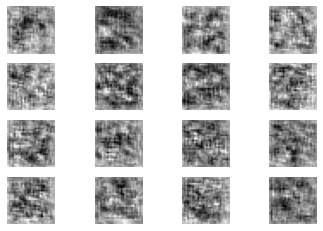

1000 [D loss: 0.671433, acc.: 60.55%] [G loss: 0.797154]


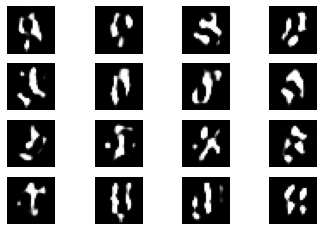

2000 [D loss: 0.727614, acc.: 53.52%] [G loss: 0.860651]


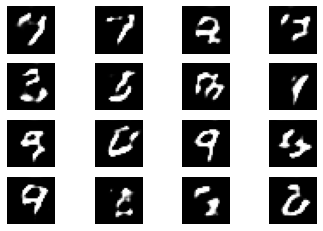

3000 [D loss: 0.658346, acc.: 56.64%] [G loss: 0.870322]


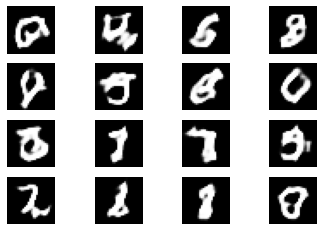

4000 [D loss: 0.686298, acc.: 57.03%] [G loss: 0.796909]


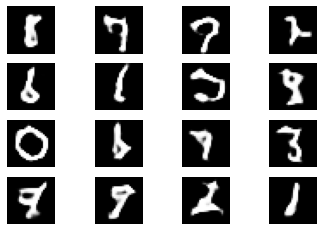

5000 [D loss: 0.655607, acc.: 61.33%] [G loss: 0.840547]


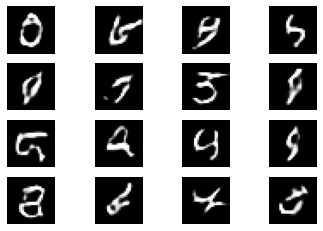

6000 [D loss: 0.640709, acc.: 61.33%] [G loss: 0.895544]


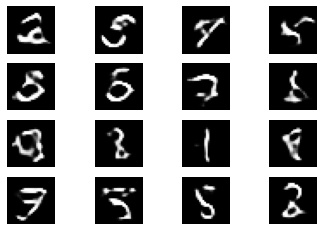

7000 [D loss: 0.689755, acc.: 54.69%] [G loss: 0.819430]


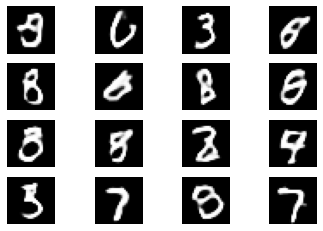

8000 [D loss: 0.617580, acc.: 64.45%] [G loss: 0.889947]


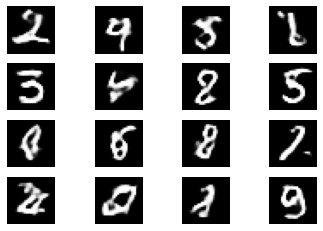

9000 [D loss: 0.663344, acc.: 61.33%] [G loss: 0.807902]


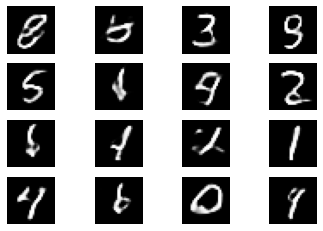

10000 [D loss: 0.676451, acc.: 55.86%] [G loss: 0.793658]


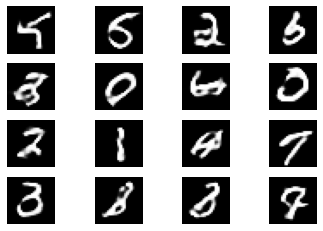

11000 [D loss: 0.624823, acc.: 64.45%] [G loss: 1.016249]


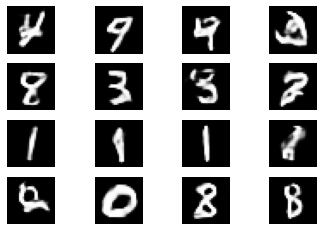

12000 [D loss: 0.661863, acc.: 60.16%] [G loss: 0.898578]


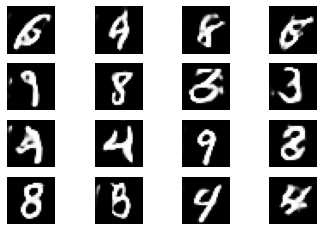

13000 [D loss: 0.586168, acc.: 70.31%] [G loss: 0.900629]


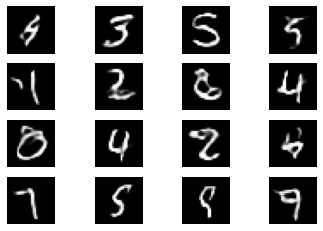

14000 [D loss: 0.638247, acc.: 66.02%] [G loss: 0.815282]


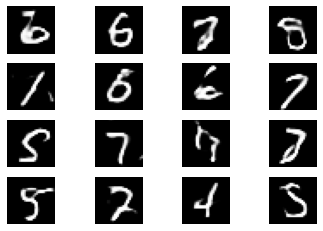

15000 [D loss: 0.661467, acc.: 62.50%] [G loss: 0.868632]


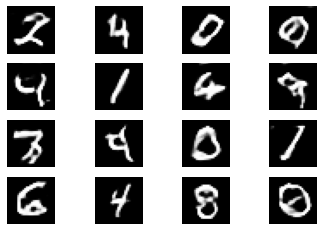

16000 [D loss: 0.665732, acc.: 57.81%] [G loss: 0.832834]


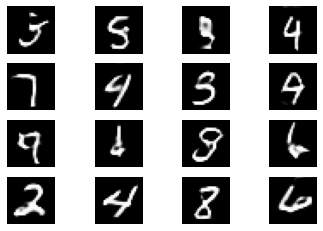

17000 [D loss: 0.683387, acc.: 57.03%] [G loss: 0.859176]


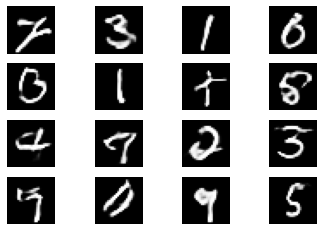

18000 [D loss: 0.652649, acc.: 62.11%] [G loss: 0.820533]


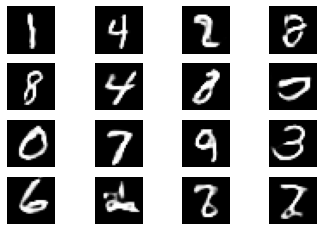

19000 [D loss: 0.668803, acc.: 57.03%] [G loss: 0.803098]


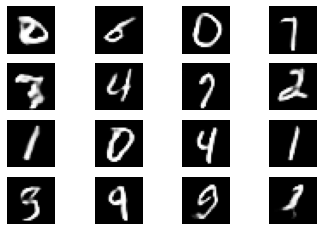

19999 [D loss: 0.649927, acc.: 42.19%] [G loss: 0.945935]


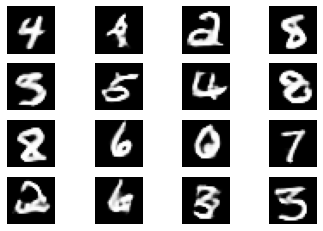

In [107]:
discriminator = def_discriminator()
optimizer = Adam(0.0001) 
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
generator = def_generator()
z = Input(shape=(100,))  
img = generator(z)

discriminator.trainable = False  

valid = discriminator(img) 



combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

graph_data=[]
train(epochs=20000, batch_size=64, save_interval=1000)

In [108]:

# print( os.listdir() )m 
# print(os.getcwd())
# from google.colab import files
# files.download( "gan_4999.png" ) 



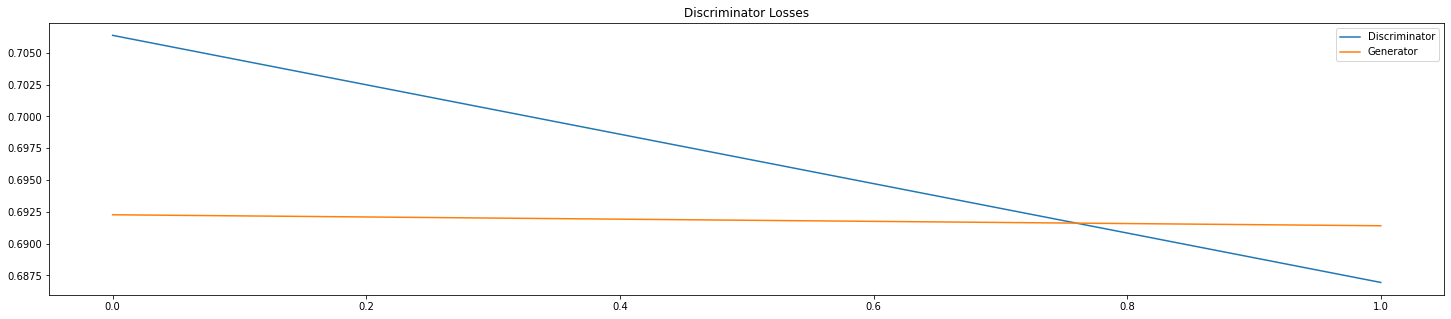

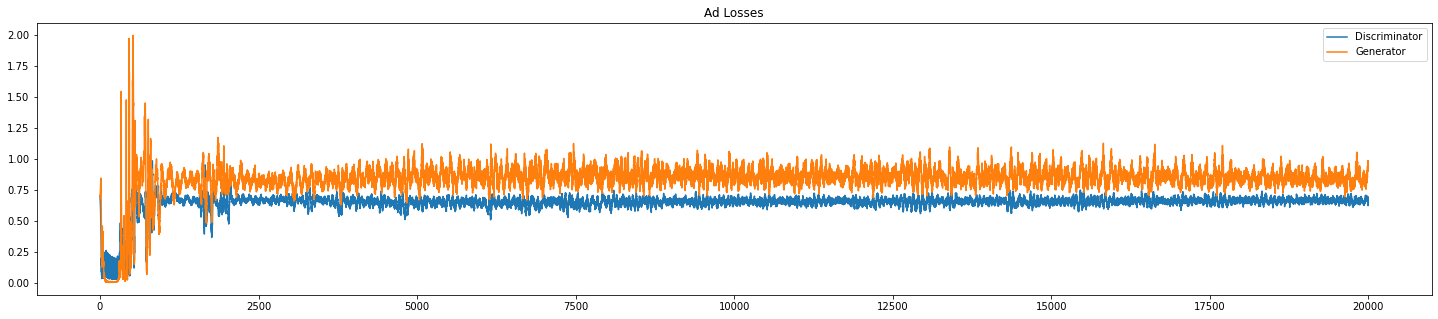

In [109]:
losses = np.array(graph_data)


fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(losses[0], label='Discriminator')
plt.plot(losses[1], label='Generator')

plt.title("Discriminator Losses")
plt.legend()


fig, ax = plt.subplots(figsize=(25, 5))
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')


plt.title("Ad Losses")
plt.legend()

In [110]:
np.zeros((half_batch,1)).shape

(128, 1)

In [111]:

# def train_step(images):
#     noise = np.random.randn(100, 100).astype("float32")

#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#       generated_images = generator(noise, training=True)
#       #print(generated_images)
#       real_output = dis_model(images, training=True)
#       #print(real_output)
#       fake_output = dis_model(generated_images, training=True)
#       #print(fake_output)
#       gen_loss = generator_loss(fake_output)
#       # print(gen_loss)
#       disc_loss = discriminator_loss(real_output, fake_output)

#     gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
#     gradients_of_discriminator = disc_tape.gradient(disc_loss, dis_model.trainable_variables)

#     generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
#     discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis_model.trainable_variables))
#     #print(gen_loss)
#     print("gen loss: ", np.mean(gen_loss))
#     print("dis loss: " ,np.mean(disc_loss))


In [112]:
# def train(ds,epochs):
#   for i in range(epochs):
#     for images in ds:
#       # images= tf.cast(images,tf.dtypes.float32)
#       train_step(images)
# train(x_train_ds,1)

(28, 28)
[[0.4001372]]


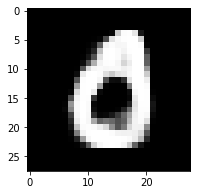

In [116]:
plt.subplots(figsize=(3, 3))
#gen_imgs = 0.5 * generator(np.random.randn(1,100)) + 0.5
gen_imgs =  generator(np.random.randn(1,100)) 
pred_input= tf.reshape(gen_imgs,(28,28))
plt.imshow(pred_input,cmap="gray")
print(pred_input.shape)
pred_input= tf.reshape(pred_input,(1,28,28,1))
print(discriminator.predict(pred_input))

In [114]:
from keras.utils import to_categorical
testY = to_categorical(y_test)
print(testY[0])
#print(discriminator.evaluate(pred_input))
_,acc =discriminator.evaluate(x_test, y_test, verbose=1)
print('> %.3f' % (acc * 100.0))



[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
313/313 [==============================] - 1s 2ms/step - loss: 110.0176 - accuracy: 0.0821
> 8.210
